In [3]:
import tensorflow as tf
import numpy as np
import pickle
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
tf.__version__

'1.14.0'

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data')

W1012 20:20:44.030955 140098860484416 deprecation.py:323] From <ipython-input-5-a4cb33905eda>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1012 20:20:44.032122 140098860484416 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1012 20:20:44.034222 140098860484416 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a futur

Extracting ./MNIST_data/train-images-idx3-ubyte.gz


W1012 20:20:44.366255 140098860484416 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W1012 20:20:44.443828 140098860484416 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


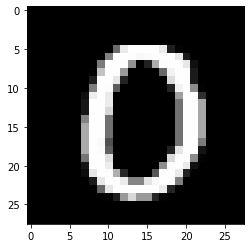

In [6]:
i = 10
img = mnist.train.images[i]
plt.imshow(img.reshape((28,28)), cmap='Greys_r')

In [7]:
def get_inputs(noise_dim,image_height,image_width,image_depth):
    """
    :param noise_dim: 噪声图片的size
    :param image_height: 真实图像的height
    :param image_width: 真实图像的width
    :param image_depth: 真实图像的depth
    """
    inputs_real =tf.placeholder(tf.float32,[None,image_width,image_height,image_depth],name='inputs_real')
    inputs_noise =tf.placeholder(tf.float32,[None,noise_dim],name='inputs_noise')
    
    return inputs_real, inputs_noise

In [8]:
def get_inputs(noise_dim,image_height,image_width,image_depth):
    """
    :param noise_dim: 噪声图片的size
    :param image_height: 真实图像的height
    :param image_width: 真实图像的width
    :param image_depth: 真实图像的depth
    """
    inputs_real =tf.placeholder(tf.float32,[None,image_width,image_height,image_depth],name='inputs_real')
    inputs_noise =tf.placeholder(tf.float32,[None,noise_dim],name='inputs_noise')
    
    return inputs_real, inputs_noise

def get_generator(noise_img,output_dim,is_train=True,alpha=0.01):
    """
    :param noise_img: 噪声信号，tensor类型
    :param output_dim: 生成图片的depth
    :param is_train: 是否为训练状态，该参数主要用于作为batch_normalization方法中的参数使用
    :param alpha: Leaky ReLU系数
    """
    with tf.variable_scope("generator",reuse=(not is_train)):
        # 100 x 1 to 4 x 4 x 512
        # 全连接层
        layer1 = tf.layers.dense(noise_img,4*4*512)
        layer1 = tf.reshape(layer1,[-1,4,4,512])
        layer1 = tf.layers.batch_normalization(layer1,training=is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        layer1 = tf.nn.dropout(layer1,keep_prob=0.8)
        # 4 x 4 x 512 to 7 x 7 x 256
        layer2 = tf.layers.conv2d_transpose(layer1,256,4, stride=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2,training=is_train)
        layer2 = tf.maximum(alpha*layer2,layer2)
        layer2 = tf.nn.dropout(layer2,keep_prob=0.8)
        # 7 x 7 256 to 14 x 14 x 128
        layer3 = tf.layers.conv2d_transpose(layer2,128,3,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3,training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        layer3 = tf.nn.dropout(layer3,keep_prob=0.8)
        # 14 x 14 x 128 to 28 x 28 x 1
        logits = tf.layers.conv2d_transpose(layer3,output_dim,3,strides=2,padding='same')
        # MNIST原始数据集的像素范围在0-1，这里的生成图片范围为(-1,1)
        # 因此在训练时，记住要把MNIST像素范围进行resize
        outputs = tf.tanh(logits)
        
        return outputs     